In [1]:
import pandas as pd
import ast
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.style as mplstyle
from tqdm import tqdm
jet = plt.cm.jet
import datetime
# Invert the colormap
colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)
colors = [jet(x) for x in np.linspace(0.5, 1, 256)]
red_to_green = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)
data = pd.read_csv('today_lane_data.csv')

In [2]:
data

,time_unix,milemarker,speed,volume,occupancy,lane1_speed,lane1_volume,lane1_occ,lane2_speed,lane2_volume,lane2_occ,lane3_speed,lane3_volume,lane3_occ,lane4_speed,lane4_volume,lane4_occ
0,1.702073e+09,61.5,65.0,57.0,16.0,69.0,14.0,11.0,64.0,13.0,18.0,62.0,14.0,21.0,65.0,16.0,15.0
1,1.702073e+09,57.3,68.0,41.0,10.0,76.0,11.0,8.0,70.0,10.0,8.0,67.0,11.0,15.0,61.0,9.0,10.0
2,1.702073e+09,57.7,68.0,45.0,10.0,73.0,15.0,10.0,70.0,12.0,9.0,64.0,11.0,15.0,64.0,7.0,6.0
3,1.702073e+09,54.1,60.0,33.0,8.0,67.0,10.0,9.0,61.0,9.0,10.0,62.0,7.0,6.0,51.0,7.0,7.0
4,1.702073e+09,63.6,70.0,43.0,11.0,78.0,12.0,8.0,71.0,9.0,15.0,69.0,13.0,11.0,61.0,9.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65779,1.702033e+09,68.5,71.0,8.0,2.0,NaN,0.0,0.0,71.0,3.0,2.0,72.0,3.0,4.0,72.0,2.0,1.0
65780,1.702033e+09,69.3,66.0,7.0,2.0,NaN,0.0,0.0,71.0,1.0,1.0,69.0,2.0,1.0,64.0,4.0,5.0
65781,1.702033e+09,69.8,67.0,5.0,2.0,66.0,1.0,1.0,63.0,1.0,1.0,69.0,3.0,4.0,NaN,0.0,0.0
65782,1.702033e+09,67.3,71.0,10.0,2.0,NaN,0.0,0.0,78.0,4.0,2.0,64.0,3.0,2.0,71.0,3.0,2.0


In [3]:
smooth_x_window = 1
smooth_t_window = 200
def beta_free(x,t,x_s,t_s,x_win=smooth_x_window,t_win=smooth_t_window,c_free=-80):
    dt = t-t_s- 3600*(x-x_s)/c_free
    dx = x-x_s
    return np.exp(-(np.abs(dx)/x_win + np.abs(dt)/t_win))

def beta_cong(x,t,x_s,t_s,x_win=smooth_x_window,t_win=smooth_t_window,c_cong=10):
    dt = t-t_s- 3600*(x-x_s)/c_cong
    dx = x-x_s
    return np.exp(-(np.abs(dx)/x_win + np.abs(dt)/t_win))

def EGTF(x,t,speed_raw_df):
    speed = speed_raw_df[(np.abs(speed_raw_df.t - t)<=(smooth_t_window/2)) & (np.abs(speed_raw_df.x - x)<=(smooth_x_window/2))].copy()
    
    speed = speed.dropna()
#     print(len(speed))
    EGTF_v_free = 80
    EGTF_v_cong = 80
    # Now apply your functions
    speed['beta_free'] = speed.apply(lambda v: beta_free(x, t, v.x, v.t), axis=1)
    speed['beta_cong'] = speed.apply(lambda v: beta_cong(x, t, v.x, v.t), axis=1)
    if((sum(speed.beta_free)!=0) & (sum(speed.beta_cong)!=0)):
        EGTF_v_free = sum(speed.beta_free * speed.speed) / sum(speed.beta_free)
        EGTF_v_cong = sum(speed.beta_cong * speed.speed) / sum(speed.beta_cong)
#         print(EGTF_v_free,EGTF_v_cong)
    v = min(EGTF_v_free,EGTF_v_cong)
    tanh_term = np.tanh( (36-v) / 3.1)
    w = 0.5*(1+tanh_term)
#     return speed, w*EGTF_v_cong + (1-w)*EGTF_v_free
    return w*EGTF_v_cong + (1-w)*EGTF_v_free

100%|████████████████████████████████████| 65807/65807 [01:13<00:00, 890.04it/s]


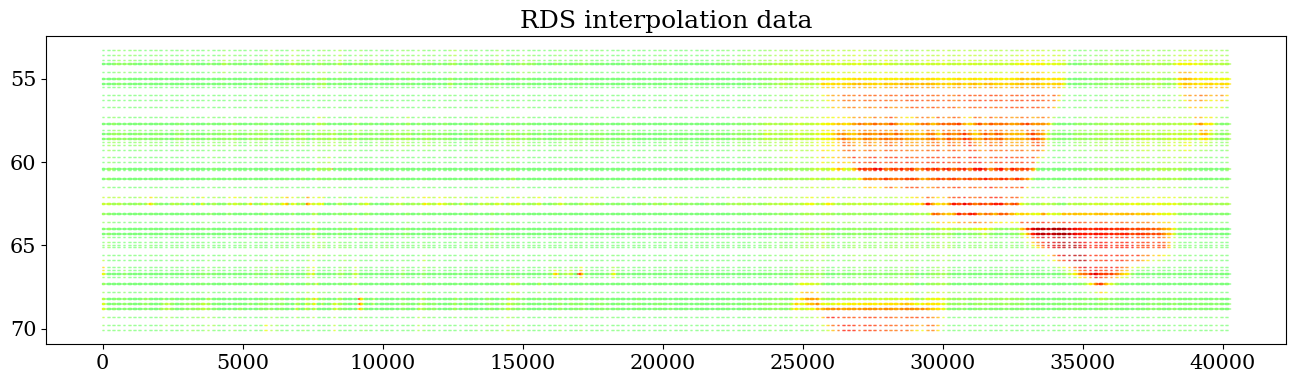

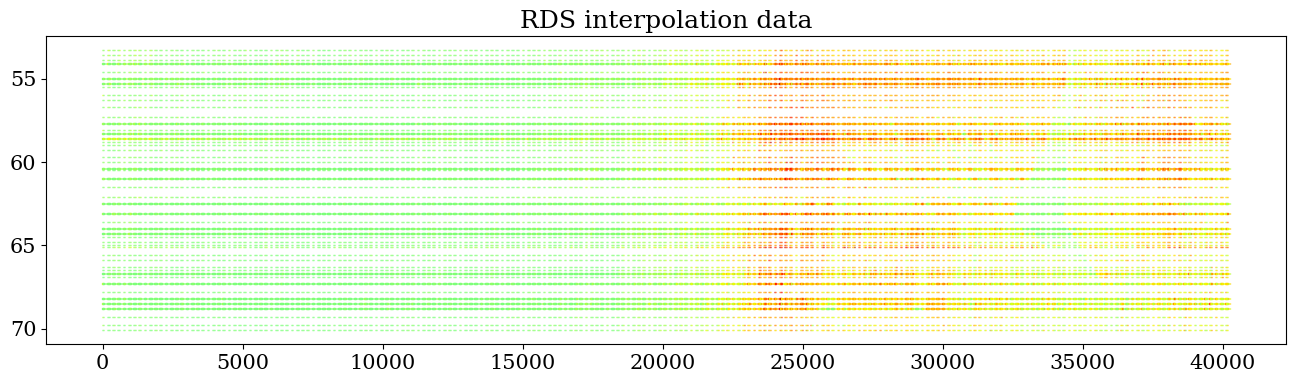

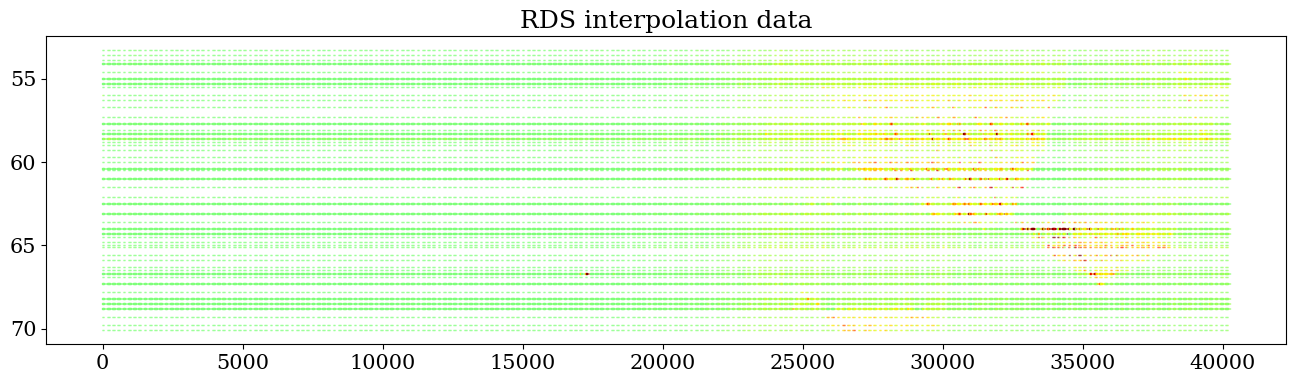

100%|████████████████████████████████████| 65807/65807 [01:17<00:00, 850.28it/s]


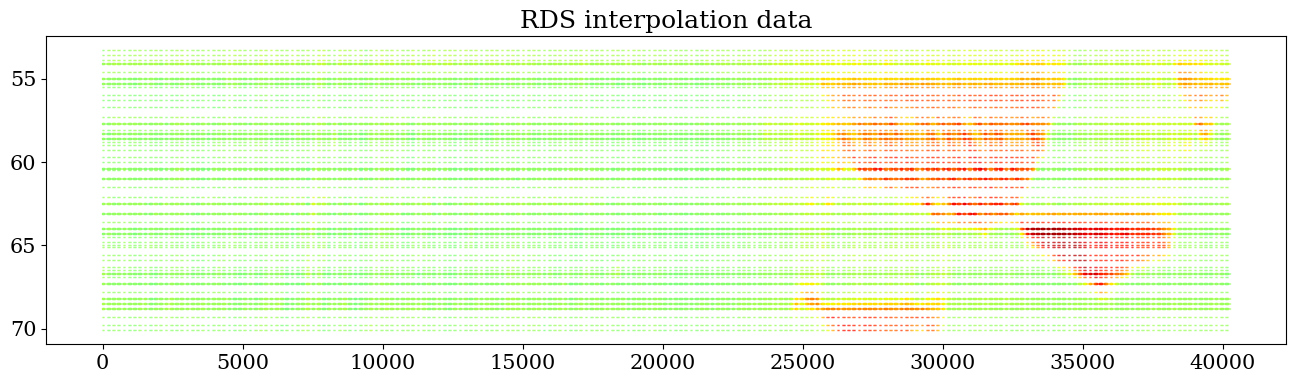

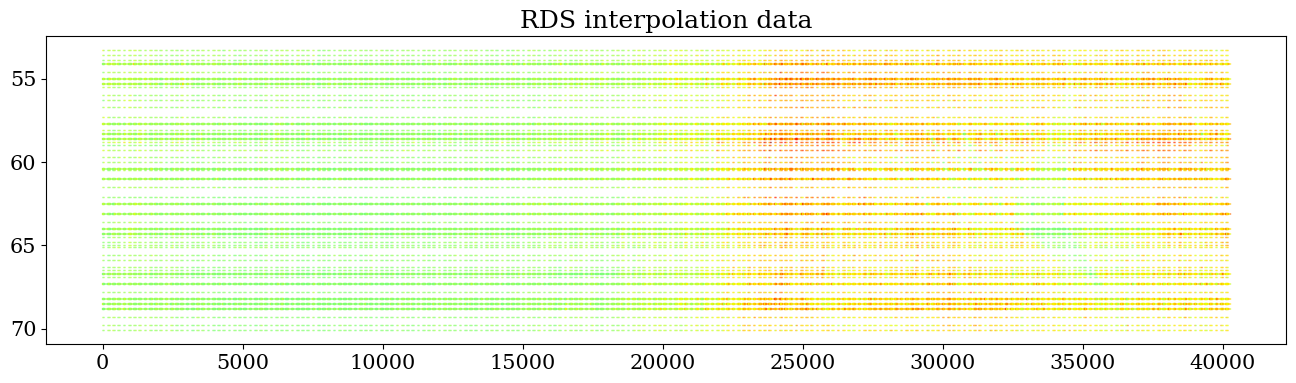

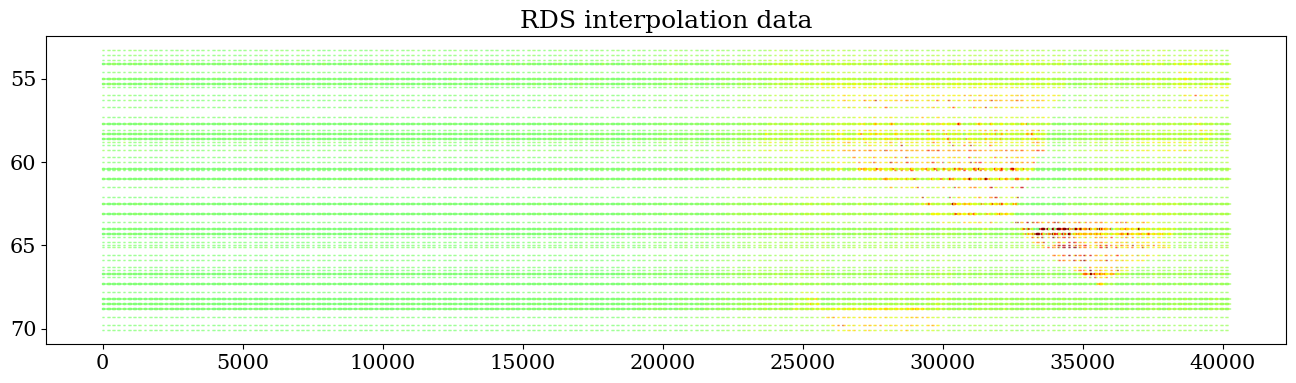

100%|████████████████████████████████████| 65807/65807 [01:17<00:00, 853.54it/s]


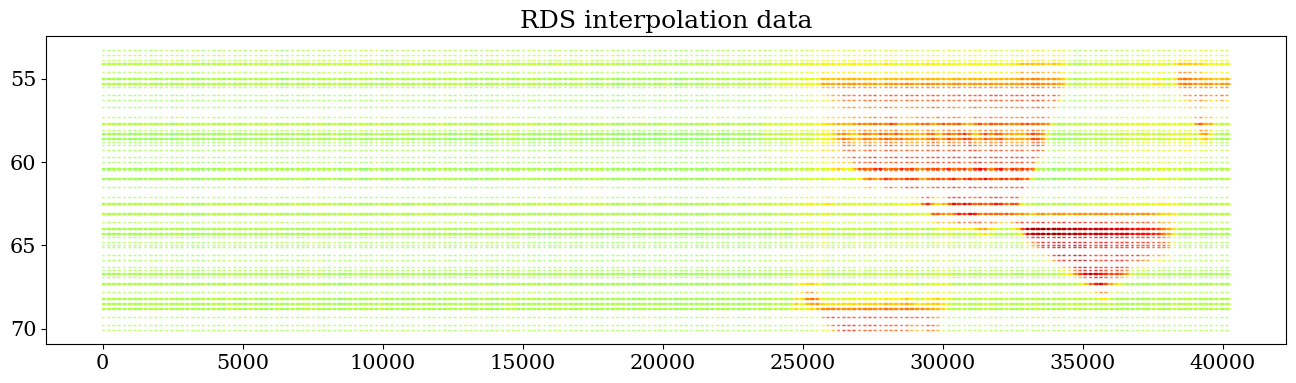

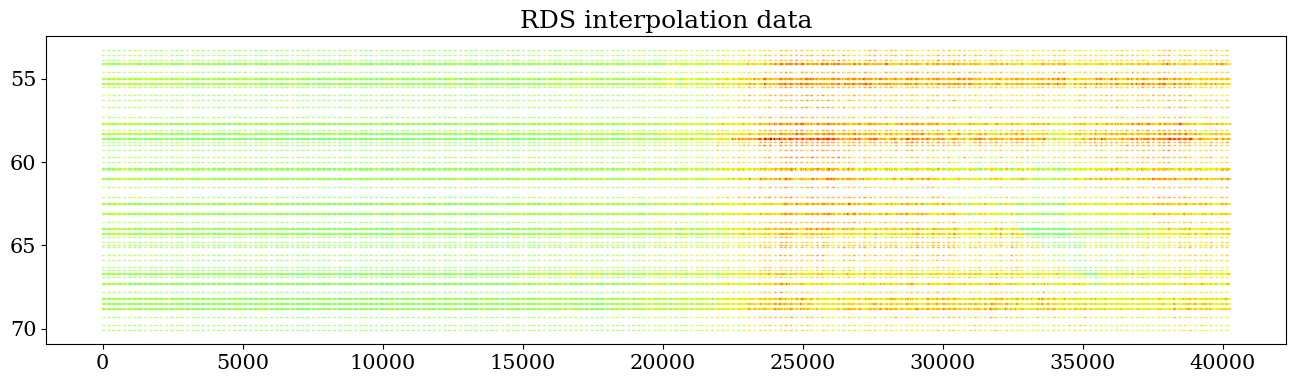

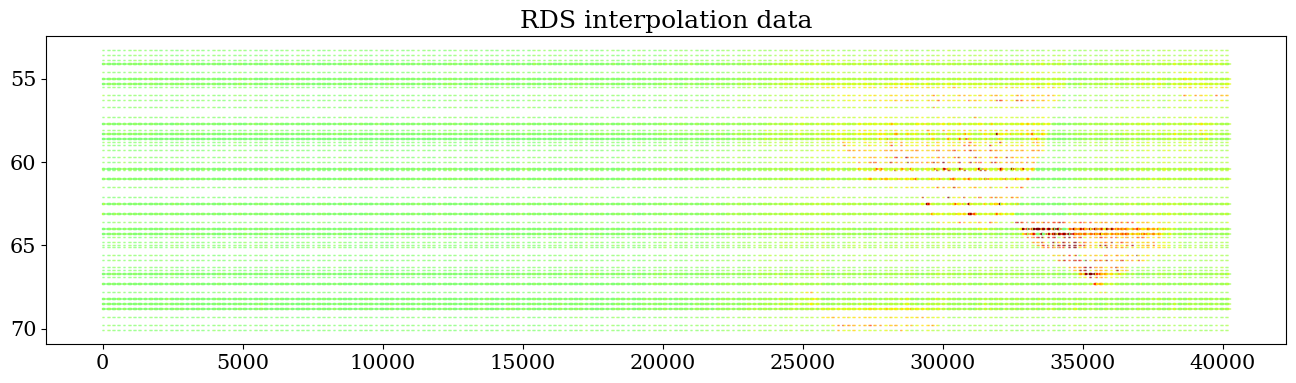

100%|████████████████████████████████████| 65807/65807 [01:15<00:00, 876.90it/s]


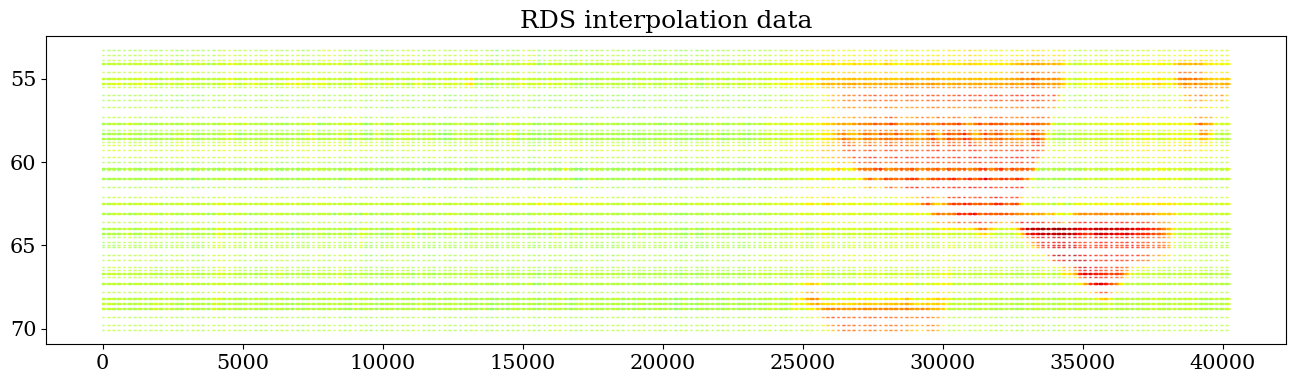

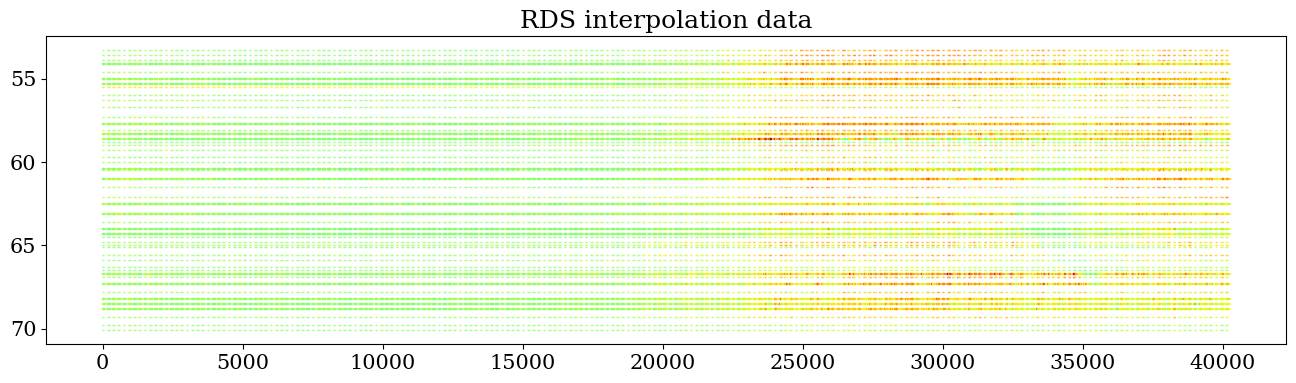

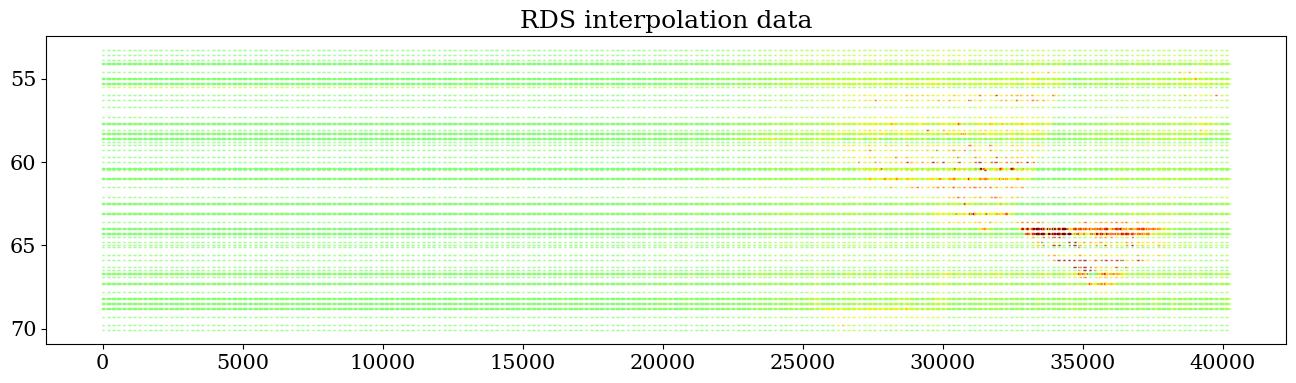

In [5]:
folder = 'today_process'
for process_day in range(1,2):
    for process_lane in range(1,5):
        for process_var in ['speed','volume','occ']:
            # process_var = 'volume'
            lane_data = data[['time_unix','milemarker',f'lane{process_lane}_{process_var}']]
            lane_data.columns = ['time_unix','milemarker',process_var]
            first_unix_time = lane_data.time_unix.min()
            lane_data['time'] = lane_data['time_unix'] - first_unix_time 
            lane_data['time_index'] = lane_data['time']//30
            lane_day = lane_data[(lane_data.time>0 + 3600*24*(process_day-1)) & (lane_data.time<=3600*24*(process_day))]
            lane_day = lane_day.dropna().reset_index(drop=True)
            # Time range from 0 to 43200 every 30 seconds
            time = np.arange(round(lane_day.time_index.min(),0), round(lane_day.time_index.max(),0), 1)
            # Space values provided in the list array
            space = data.milemarker.unique()
            # space = np.arange(53.3, 70.2, 0.1)
            time_grid, space_grid = np.meshgrid(time, space)
            time_flat = time_grid.flatten()
            space_flat = space_grid.flatten()
            ld_full = pd.DataFrame({'time_index': time_flat, 'milemarker': space_flat})
            ld_full['milemarker'] = ld_full['milemarker'].apply(lambda v: round(v,2))
            ld_full['var'] = ld_full.apply(lambda v: 
                                                 lane_day[(lane_day.time_index == v.time_index) & (lane_day.milemarker == v.milemarker)][f'{process_var}'].mean(),axis=1)
            ld_full['time'] = ld_full['time_index']*30
            if(process_var == 'speed'):
                ld_full.columns = ['time_index','x','speed','t']
                raw_data = ld_full.copy()
                # raw_data = raw_data.sort_values(by=['t', 'x'])
                raw_data = raw_data.sort_values(by=[ 'x','t']).reset_index(drop=True)
                raw_data['raw_speed'] = raw_data[f'{process_var}']
                tqdm.pandas()
                # raw_data['speed'] = raw_data.progress_apply(lambda v: v.speed if v.speed < 90 else EGTF(v.x, v.t, raw_data), axis=1)
                raw_data['speed'] = raw_data.progress_apply(lambda v: EGTF(v.x, v.t, raw_data), axis=1)
                raw_data.columns = ['time_index','milemarker',process_var,'time',f'raw_{process_var}']
                raw_data['unix_time'] = raw_data['time'] + first_unix_time
                raw_data.to_csv(f'{folder}/day_{process_day}_lane{process_lane}_{process_var}.csv')
                plt.figure(figsize=(16,4), facecolor='white')
                plt.rc('font', family='serif', size=15)
                sc = plt.scatter(raw_data.time.values , raw_data.milemarker.values, 
                                c=raw_data[f'{process_var}'].values,vmin=0,vmax=80,marker='s',
                                cmap=green_to_red,s=0.1)
                plt.gca().invert_yaxis()
                plt.title('RDS interpolation data')
                plt.show()
            if(process_var != 'speed'):
                ld_full.columns = ['time_index','x','var','t']
                raw_data = ld_full.copy()
                raw_data[f'raw_{process_var}'] = raw_data['var']
                raw_data = raw_data.sort_values(by=[ 'x','t']).reset_index(drop=True)
                raw_data['var'] = raw_data['var'].interpolate(method='linear')
                raw_data.columns = ['time_index','milemarker',process_var,'time',f'raw_{process_var}']
                raw_data['unix_time'] = raw_data['time'] + first_unix_time
                raw_data.to_csv(f'{folder}/day_{process_day}_lane{process_lane}_{process_var}.csv')
                plt.figure(figsize=(16,4), facecolor='white')
                plt.rc('font', family='serif', size=15)
                sc = plt.scatter(raw_data.time.values , raw_data.milemarker.values, 
                                c=raw_data[f'{process_var}'].values,marker='s',
                                cmap=red_to_green,s=0.1)
                plt.gca().invert_yaxis()
                plt.title('RDS interpolation data')
                plt.show()